In [17]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from  pandasgui import show
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import cross_val_predict
from sklearn.discriminant_analysis import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc

In [18]:
pd.set_option("display.max_columns", None)
warnings.filterwarnings("ignore")
train_data = pd.read_csv('../data/airline_passenger_satisfaction.csv')
train_data['satisfaction'] = (train_data['satisfaction'] == 'satisfied').astype(int)
print(train_data.info())
show(train_data)
# primeros_100_registros = train_data.iloc[:100]
# test_data = pd.DataFrame(primeros_100_registros)
primer_registro = train_data.iloc[0]
test_data = pd.DataFrame([primer_registro])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 25 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Unnamed: 0                         103904 non-null  int64  
 1   id                                 103904 non-null  int64  
 2   Gender                             103904 non-null  object 
 3   Customer Type                      103904 non-null  object 
 4   Age                                103904 non-null  int64  
 5   Type of Travel                     103904 non-null  object 
 6   Class                              103904 non-null  object 
 7   Flight Distance                    103904 non-null  int64  
 8   Inflight wifi service              103904 non-null  int64  
 9   Departure/Arrival time convenient  103904 non-null  int64  
 10  Ease of Online booking             103904 non-null  int64  
 11  Gate location                      1039

In [19]:
#obtenemos un arreglo con los nombres de las variables segun su tipo
imputer_cols = [cname for cname in train_data.columns if train_data[cname].dtype in ['int64', 'float64']]
categorical_cols = [cname for cname in train_data.columns if train_data[cname].dtype == "object"]

In [20]:
imputer = SimpleImputer(strategy='mean' )
imputer.fit(train_data[imputer_cols])
train_data[imputer_cols] = imputer.transform(train_data[imputer_cols])
test_data[imputer_cols] = imputer.transform(test_data[imputer_cols])

In [21]:
# completamos valores nulos  en las columnas categoricas con la moda
def fill_null_with_mode(column, train_df, test_df):
    moda = train_df[column].mode().iloc[0]
    train_df[column] = train_df[column].fillna(moda)
    test_df[column] = test_df[column].fillna(moda)

# Aplicar la función de llenado de valores nulos
fill_null_with_mode(categorical_cols, train_data, test_data)

In [22]:
#preparamos los datos para dividirlos
train_data.drop(["Unnamed: 0" ,"id"] , axis = 1 ,inplace = True)
test_data.drop(["Unnamed: 0" ,"id","satisfaction"] , axis = 1 ,inplace = True)
X = train_data.drop("satisfaction" , axis =1 )
y = train_data["satisfaction"]


In [23]:
# encoding y escaling
numerical_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]
print(numerical_cols)
categorical_cols = [cname for cname in X.columns if X[cname].dtype == "object"]
print(categorical_cols)
boolean_cols = [cname for cname in X.columns if X[cname].dtype == 'bool']
print(boolean_cols)

# Scale numerical data to have mean=0 and variance=1
numerical_transformer = Pipeline(steps=[('scaler', MinMaxScaler())])

# One-hot encode categorical data
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(drop='if_binary', handle_unknown='ignore',sparse=False))])

# Combine preprocessing
ct = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)],
        remainder='passthrough')

# Apply preprocessing
X = ct.fit_transform(X)
test_data = ct.transform(test_data)

# Print new shape
print('Training set shape:', X.shape)

['Age', 'Flight Distance', 'Inflight wifi service', 'Departure/Arrival time convenient', 'Ease of Online booking', 'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort', 'Inflight entertainment', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Inflight service', 'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']
['Gender', 'Customer Type', 'Type of Travel', 'Class']
[]
Training set shape: (103904, 24)


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,train_size=0.8,test_size=0.2,random_state=0)

In [25]:
my_pipeline = Pipeline(steps=[
    ('model', RandomForestClassifier(n_estimators=50))
])

# Realizar la validación cruzada y obtener las probabilidades y los scores
proba_predictions = cross_val_predict(my_pipeline, X, y, cv=10, method='predict_proba')
accuracy_scores = cross_val_predict(my_pipeline, X, y, cv=10, method='predict')

# Calcular promedio de las probabilidades de la clase positiva
preds = proba_predictions[:, 1].mean()

# Calcular promedio del score de precisión
# average_accuracy = accuracy_score(y, accuracy_scores)

# Imprimir los resultados
print("Average probability:", preds)
# print("Average accuracy:", average_accuracy)

Average probability: 0.43356579149984603


In [26]:
classifier = RandomForestClassifier(n_estimators=50)
classifier.fit(X_train,y_train)

RandomForestClassifier(n_estimators=50)

In [27]:
classifier.predict(test_data)


array(['neutral or dissatisfied'], dtype=object)

In [28]:
y_pred = classifier.predict(X_test)

In [29]:
# Calcular promedio de las probabilidades de la clase positiva
preds = proba_predictions[:, 1].mean()

# Calcular promedio del score de precisión
average_accuracy = accuracy_score(y, accuracy_scores)

#Matriz
conf_matrix = confusion_matrix(y_test, y_pred)

# Calcula la precisión
precision = precision_score(y_test, y_pred, average='macro')

# Calcula el recall
recall = recall_score(y_test, y_pred, average='macro')

# Calcula el F1-Score
f1 = f1_score(y_test, y_pred, average='macro')

# Imprimir los resultados
print("Average probability:", preds)
print("Average accuracy:", average_accuracy)
print("Matriz de Confusión:\n", conf_matrix)
print(f"Precisión: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")


Average probability: 0.43356579149984603
Average accuracy: 0.961878272251309
Matriz de Confusión:
 [[11519   257]
 [  568  8437]]
Precisión: 0.96
Recall: 0.96
F1-Score: 0.96


**Average probability**  
Esto nos indica que de la cantidad de clientes satisfechos (satisfied) hay un 43.35% del total general , por lo tanto lo restante serian los que estan como "neutral or dissatisfied".

**Average accuracy**  
Aqui podemos observar que en cuanto a predicciones correctas, es decir que nuestro modelo cuenta con un 96.15% de acertividad en cuanto a las pruebas realizadas.

**Matriz de confusión**  
La matriz de confusión es la variable que nos permite determinar la capacidad del modelo para evitar clasificar incorrectamente las instancias negativas como positivas. A diferencia de la precisión uqe nos da una vision general de la acertividad , la matriz de confusión se utiliza para saber la categorizacion de las predicciones.

En esta métrica nos indica cuantos verdaderos positivos hay (11510) es decir que la mayoria de resultados aqui estan estado "satisfied"; Falsos positivos aqui se puede ver que el modelo interpretó 266 clientes que en realidad estan en estado  "neutral or dissatisfied" pero que el modelo tomó como "satisfied"; En cuanto a 579 , nos indica que el modelo interpreta estos datos como falsos negativos , que quiere decir que en realidad estos clientes estan como "satisfied" pero el modelo los tomó como "neutral or dissatisfied"; por último 8426 que significa que aqui estan los verdaderos negativos , que aqui todos los clientes estan como "neutral or dissatisfied".

**Precisión**  
Esto nos indica que de toda la base de datos el 96% es acertado con respecto a predicciones positivas, a diferencia de ka atriz de confusión , la precisión no tiene en cuenta estos falsos positivos y se centra en la proporción de predicciones positivas correctas en relación con todas las predicciones positivas. 

**Recall**  
El recall responde a la pregunta: "De todos los casos positivos reales, ¿cuántos de ellos el modelo fue capaz de identificar correctamente?". Es una métrica importante en problemas donde la detección de todos los casos positivos es crítica, como en la detección temprana de enfermedades o la identificación de fraudes. En este caso se puede determinar que el 96% de de los casos verdaderos positivos es correctamente identificado por el modelo.

**F1-Score**  
El F1-Score es útil cuando deseamos tener un equilibrio entre la precisión y el recall. Proporciona una puntuación que combina ambas métricas y es útil cuando ninguna de las dos métricas por sí sola es suficiente. En nuestro caso indica que está cerca al 1.0 entonces indica un buen equilibrio entre la precisión y el recall.


In [30]:
# Obtiene la importancia de las características
importancia_caracteristicas = classifier.feature_importances_

# Puedes imprimir la importancia de cada característica
for i, importancia in enumerate(importancia_caracteristicas):
    print(f'Característica {i}: {importancia}')

Característica 0: 0.03325999657941279
Característica 1: 0.0401563273887592
Característica 2: 0.14418448289547964
Característica 3: 0.01813385765183483
Característica 4: 0.03435661217116654
Característica 5: 0.016318512310547147
Característica 6: 0.011858308667845374
Característica 7: 0.1670645930697651
Característica 8: 0.045459044555727184
Característica 9: 0.057154606674689114
Característica 10: 0.03190892801346655
Característica 11: 0.037515329149405474
Característica 12: 0.023360416224196715
Característica 13: 0.024390526279785153
Característica 14: 0.02456398117958776
Característica 15: 0.02308124002371134
Característica 16: 0.011171660367061078
Característica 17: 0.012794307517173606
Característica 18: 0.0044375338251498725
Característica 19: 0.02986970554519107
Característica 20: 0.0887351700402432
Característica 21: 0.06776046642039667
Característica 22: 0.04867106437653869
Característica 23: 0.0037933290728660294


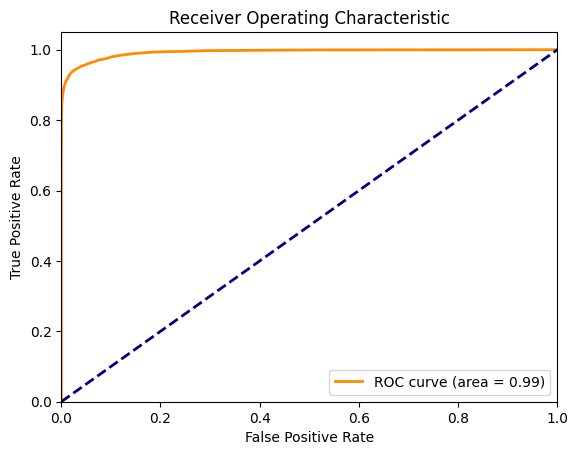

In [31]:
# Mapea las etiquetas a valores binarios
y_true_binary = [1 if label == "satisfied" else 0 for label in y_test]

# Obtén las probabilidades de predicción del modelo (por ejemplo, un clasificador de bosque aleatorio)
probs = classifier.predict_proba(X_test)  # X_test son las características de prueba

# Calcula la curva ROC especificando pos_label=1
fpr, tpr, umbrales = roc_curve(y_true_binary, probs[:, 1], pos_label=1)

# Calcula el área bajo la curva ROC (AUC-ROC)
roc_auc = auc(fpr, tpr)

# Grafica la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

#### Analisis de curva ROC 

En la curva de ROC podremos notar como el modelo tiene un 0.99 de acertividad a la hora de clasificar, sabiendo distinguir correctamente entre valores correctos e incorrectos con respecto al humbral. La curva de satisfechos y la curva de no satisfechos no se superponen casi en lo absoluto, permitiendo al modelo una facil identificacion y teniendo un minimo error al distinguir entre uno o el otro. 

## Tecnicas ensemble

### Gradient boosting

In [32]:
from sklearn.ensemble import GradientBoostingClassifier

my_pipeline = Pipeline(steps=[
    ('model', GradientBoostingClassifier(n_estimators=50))
])

# Validación cruzada
proba_predictions = cross_val_predict(my_pipeline, X, y, cv=10, method='predict_proba')
accuracy_scores = cross_val_predict(my_pipeline, X, y, cv=10, method='predict')

# Calcular promedio de las probabilidades de la clase positiva
preds = proba_predictions[:, 1].mean()

# Precisión
average_accuracy = accuracy_score(y, accuracy_scores)

print("Average probability:", preds)
print("Average accuracy:", average_accuracy)


Average probability: 0.43336636741148493
Average accuracy: 0.9346223437018787


### AdaBoost

In [33]:
from sklearn.ensemble import AdaBoostClassifier

my_pipeline = Pipeline(steps=[
    ('model', AdaBoostClassifier(n_estimators=50))
])

# Validación cruzada
proba_predictions = cross_val_predict(my_pipeline, X, y, cv=10, method='predict_proba')
accuracy_scores = cross_val_predict(my_pipeline, X, y, cv=10, method='predict')

# Promedio de las probabilidades de la clase positiva
preds = proba_predictions[:, 1].mean()

# Precisión
average_accuracy = accuracy_score(y, accuracy_scores)

print("Average probability:", preds)
print("Average accuracy:", average_accuracy)


Average probability: 0.49986107891201337
Average accuracy: 0.927740991684632


### Modelo ensemble Stackin utilizando ramdon Forest, Gradient Boosting y AdaBoost

In [34]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size=0.8, test_size=0.2, random_state=0)

# Entrenando los tres modelos seleccionados
random_forest = RandomForestClassifier(n_estimators=50)
adaboost = AdaBoostClassifier(n_estimators=50)
gradient_boosting = GradientBoostingClassifier(n_estimators=50)

# Modelo de nivel superior (meta-modelo)
meta_classifier = RandomForestClassifier(n_estimators=50)  # Puedes cambiar esto según tus necesidades

models = [
    ('random_forest', random_forest),
    ('adaboost', adaboost),
    ('gradient_boosting', gradient_boosting)
]

# Modelo de stacking
stacking_model = StackingClassifier(estimators=models, final_estimator=meta_classifier)

# Entreamiento del modelo stacking
stacking_model.fit(X_train, y_train)

# Predicciones
y_pred = stacking_model.predict(X_test)

# Precisión
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
print("Matriz de Confusión:\n", conf_matrix)

# precisión (Precision)
precision = precision_score(y_test, y_pred, average='macro')
print("Precisión (Macro):", precision)

# Recall
recall = recall_score(y_test, y_pred, average='macro')
print("Recall (Macro):", recall)

# F1-Score
f1 = f1_score(y_test, y_pred, average='macro')
print("F1-Score (Macro):", f1)


Accuracy: 0.9572686588710841
Matriz de Confusión:
 [[11451   325]
 [  563  8442]]
Precisión (Macro): 0.9580335859257314
Recall (Macro): 0.9549403363997658
F1-Score (Macro): 0.9563535765769524


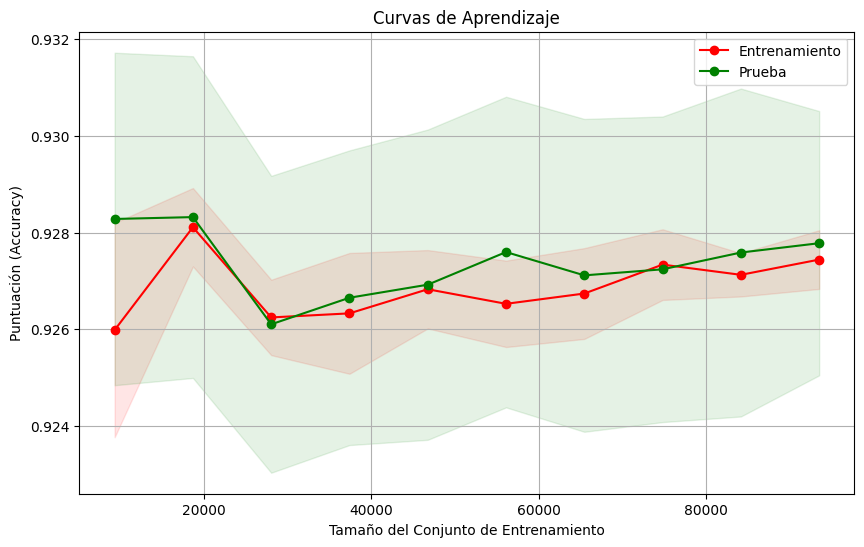

In [36]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

# Define un rango de tamaños de conjunto de entrenamiento
train_sizes, train_scores, test_scores = learning_curve(my_pipeline, X, y, cv=10, train_sizes=np.linspace(0.1, 1.0, 10))

# Calcula las medias y desviaciones estándar de las puntuaciones para el entrenamiento y prueba
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Grafica las curvas de aprendizaje
plt.figure(figsize=(10, 6))
plt.title("Curvas de Aprendizaje")
plt.xlabel("Tamaño del Conjunto de Entrenamiento")
plt.ylabel("Puntuación (Accuracy)")
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Entrenamiento")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Prueba")

plt.legend(loc="best")
plt.show()

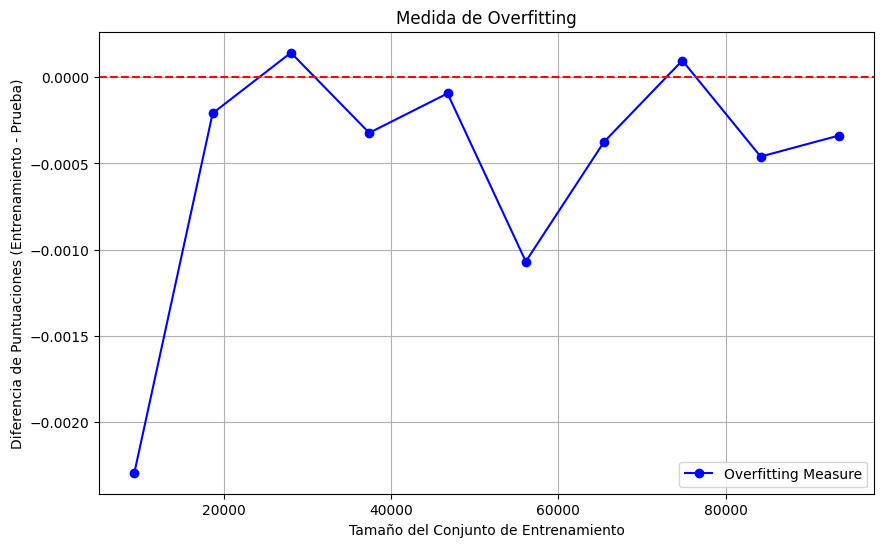

Medida de Overfitting para el último tamaño de conjunto de entrenamiento: -0.0003383595147505858


In [37]:
# Calcula la diferencia entre las puntuaciones de entrenamiento y prueba para cada tamaño de conjunto de entrenamiento
overfitting_measure = train_scores_mean - test_scores_mean

# Grafica la medida de overfitting
plt.figure(figsize=(10, 6))
plt.title("Medida de Overfitting")
plt.xlabel("Tamaño del Conjunto de Entrenamiento")
plt.ylabel("Diferencia de Puntuaciones (Entrenamiento - Prueba)")
plt.grid()

plt.plot(train_sizes, overfitting_measure, 'o-', color="b", label="Overfitting Measure")

plt.legend(loc="best")
plt.axhline(y=0, color='r', linestyle='--')  # Línea de referencia en 0

plt.show()

# Imprime la medida de overfitting para el último tamaño de conjunto de entrenamiento
print("Medida de Overfitting para el último tamaño de conjunto de entrenamiento:", overfitting_measure[-1])


In [38]:
from sklearn.metrics import accuracy_score

# Entrena tu modelo en el conjunto de entrenamiento
classifier.fit(X_train, y_train)

# Realiza predicciones en el conjunto de entrenamiento y prueba
y_train_pred = classifier.predict(X_train)
y_test_pred = classifier.predict(X_test)

# Calcula la precisión en el conjunto de entrenamiento y prueba
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Calcula el overfitting como la diferencia porcentual entre la precisión en entrenamiento y prueba
overfitting_percentage = (train_accuracy - test_accuracy) * 100

print(f"Overfitting Percentage: {overfitting_percentage:.2f}%")


Overfitting Percentage: 3.97%
